In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [6]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load cannabinoid, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("cannabinoid_receptor_data.csv") as inp:
    cannabinoid = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in cannabinoid:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "cannabinoid"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [7]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })

[12:35:41] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:35:41] ERROR: Could not sanitize molecule ending on line 20009
[12:35:41] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:35:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[12:35:44] ERROR: Could not sanitize molecule ending on line 250947
[12:35:44] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[12:35:44] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:35:44] ERROR: Could not sanitize molecule ending on line 258130
[12:35:44] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:35:44] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[12:35:44] ERROR: Could not sanitize molecule ending on line 261581
[12:35:44] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[12:35:44] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:35:44] ERROR: Could not sani

[12:35:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[12:35:47] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:35:47] ERROR: Could not sanitize molecule ending on line 519056
[12:35:47] ERROR: Explicit valence for atom # 2 O, 3, is greater than permitted
[12:35:47] Explicit valence for atom # 6 B, 4, is greater than permitted
[12:35:47] ERROR: Could not sanitize molecule ending on line 541262
[12:35:47] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[12:35:47] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[12:35:47] ERROR: Could not sanitize molecule ending on line 557517
[12:35:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[12:35:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:35:47] ERROR: Could not sanitize molecule ending on line 561344
[12:35:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:35:47] Can't kekulize mol.  Unkekulized atoms: 10 

In [8]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in cannabinoid if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [16]:
len(df)

12079

In [9]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

In [10]:
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR()

In [11]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

1443773.1179639653

In [12]:
(res[res["Source"]=="cannabinoid"]["Prediction"]-res[res["Source"]=="cannabinoid"]["Standard Value"]).abs().mean()

455135.3593553753

In [13]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error cannabinoid: {(res[res["Source"]=="cannabinoid"]["Prediction"]-res[res["Source"]=="cannabinoid"][predicted_value]).abs().mean()}""")
    return res

In [14]:
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1443773.1179639653
Average error cannabinoid: 455135.3593553753


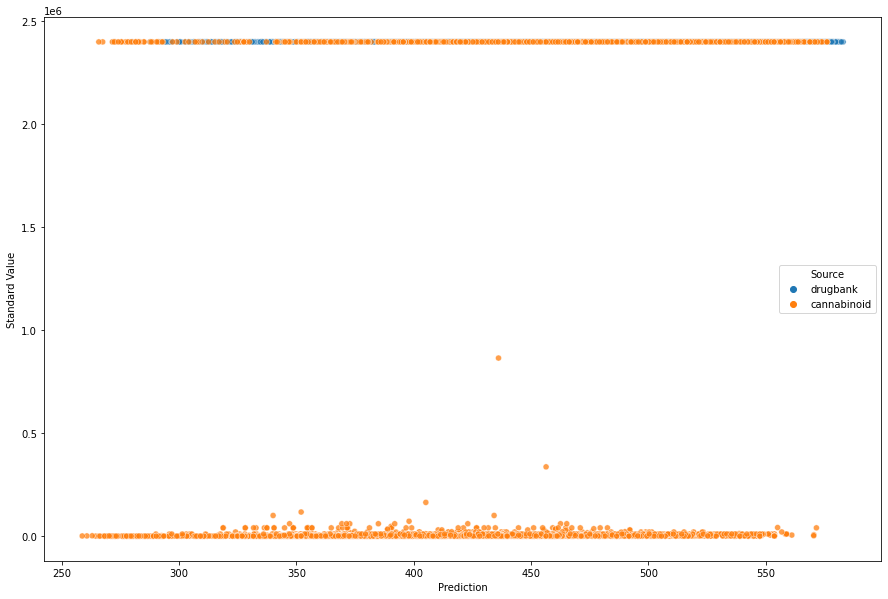

In [15]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [17]:
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [18]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [19]:
len(trainset), len(testset)

(2749, 917)

In [20]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [21]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.25963725112313196
Average error cannabinoid: 0.25963725112313196


In [22]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5167995472156102
Average error cannabinoid: 0.5167995472156102


In [23]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.66
R: 0.81
MSE: 0.47


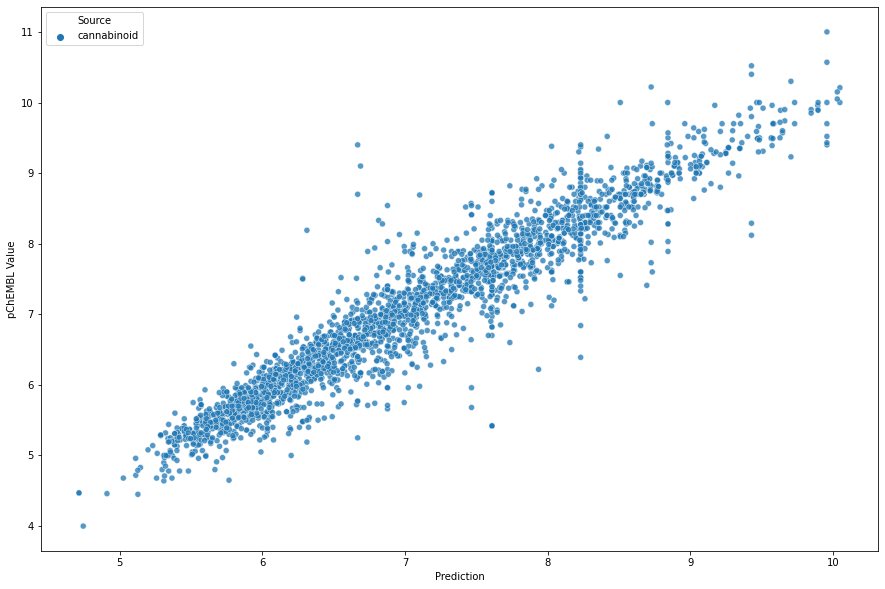

In [24]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

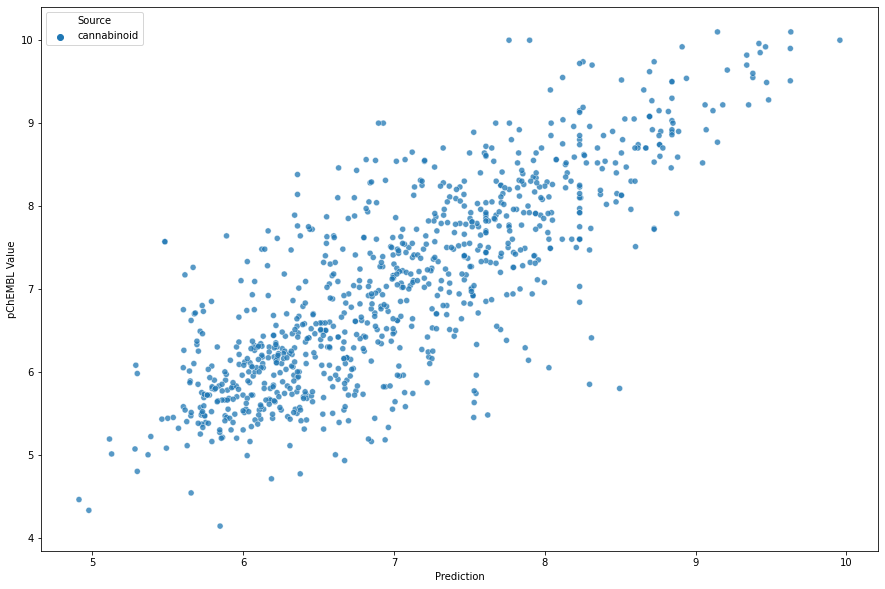

In [25]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [26]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [27]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1429800.4576937258
Average error cannabinoid: 450518.497964969


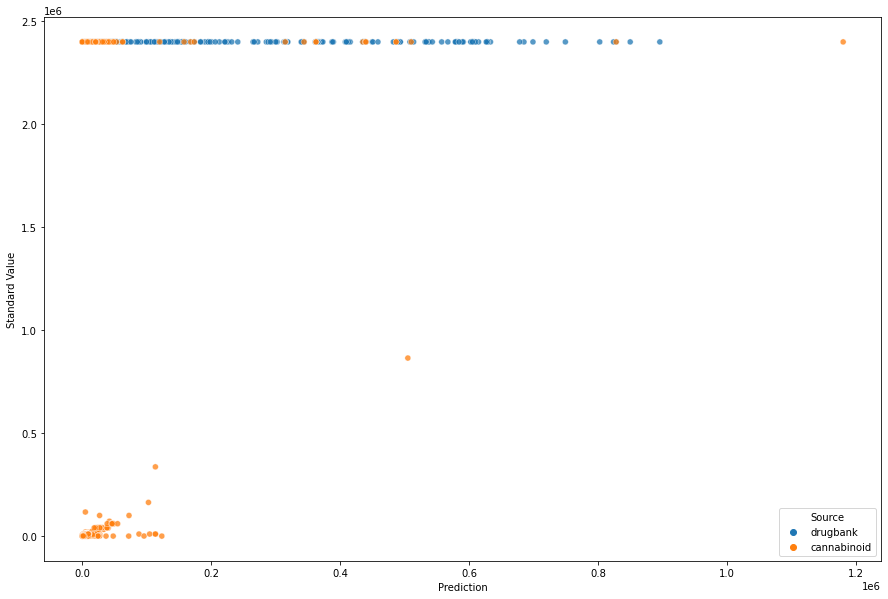

In [28]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )